**Imports**

Mount Google Drive content

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We'll be using PyTorch as it's more flexible than TensorFlow.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import os
import copy
from joblib import load
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

**Data Collection**

We'll be gathering data from Soundcharts from the following criteria:

* Small artist before a given date (< 50,000 followers)
* 1-3 songs with a standard deviation higher than their median of songs.

In [ ]:
def load_and_prepare_data(csv_path, base_path):
  # this is so sexyyyyy thanks for hstacking up here :)
    """
    Load data from CSV and prepare features from mel spectrograms and processed lyrics
    """
    print("Loading CSV file...")
    df = pd.read_csv(csv_path)

    # Initialize lists
    X_mel = []
    X_lyrics = []  # Will store pre-computed BERT features
    y_valid = []
    failed_files = []

    print("Processing files...")

    for idx, row in df.iterrows():
        try:
            # Combine base_path with relative paths
            mel_path = os.path.join(base_path, row['Mel_Spectrogram'])
            processed_lyrics_path = os.path.join(base_path, row['Processed_Lyrics_File'])

            if idx % 100 == 0:
                print(f"\nProcessing row {idx}:")
                print(f"Full mel path: {mel_path}")
                print(f"Full processed lyrics path: {processed_lyrics_path}")

            # Load mel spectrogram
            mel_spec = np.load(mel_path)
            if idx % 100 == 0:
              print(f"Loaded mel spectrogram shape: {mel_spec.shape}")
            mel_features = mel_spec.reshape(-1)  # Flatten the 2D array

            # Load pre-computed BERT features
            lyrics_features = np.load(processed_lyrics_path)
            lyrics_features = lyrics_features.flatten()  # Ensure it's 1D

            # Store features
            X_mel.append(mel_features)
            X_lyrics.append(lyrics_features)
            y_valid.append(row['Class'])

        except Exception as e:
            print(f"Error processing row {idx}: {str(e)}")
            failed_files.append((row['Artist'], row['Song']))
            continue

    if len(X_mel) == 0:
        raise ValueError("No files were successfully processed :)")

    # Convert to numpy arrays
    X_mel = np.array(X_mel)
    X_lyrics = np.array(X_lyrics)

    print(f"Mel spectrogram features shape: {X_mel.shape}")
    print(f"Lyrics features shape: {X_lyrics.shape}")

    # Combine features
    X = np.hstack([X_mel, X_lyrics])
    y = np.array(y_valid)

    print(f"\nFinal feature matrix shape: {X.shape}")
    return X, y, df

**Linear Regression Implementation**

Uses CNN to shrink the features!

In [ ]:
def run_linear_regression(csv_path, base_path):
    """Run linear regression using CNN-processed features"""
    print("\n=== Running Linear Regression Approach ===")

    # Load data using CNN data loader
    X_mel, X_lyrics, y, df = load_and_prepare_data_cnn(csv_path, base_path)

    # Initialize CNN model to extract features
    cnn_model = DualCNNMultimodalNet()

    # Function to extract features using CNN
    def extract_cnn_features(mel_data, lyrics_data):
        cnn_model.eval()
        with torch.no_grad():
            # Process mel spectrograms
            mel_input = torch.FloatTensor(mel_data)
            mel_input = mel_input.view(mel_input.size(0), 1, 80, -1)
            x1 = cnn_model.mel_conv1(mel_input)
            x2 = cnn_model.mel_conv2(x1)
            x3 = cnn_model.mel_conv3(x2)
            mel_features = cnn_model.mel_pool(x3)
            mel_features = mel_features.view(mel_features.size(0), -1)

            # Process BERT embeddings
            bert_input = torch.FloatTensor(lyrics_data)
            bert_input = bert_input.view(bert_input.size(0), 1, -1)
            bert_features = cnn_model.bert_network(bert_input)
            bert_features = bert_features.view(bert_features.size(0), -1)

            # Combine features
            combined = torch.cat((mel_features, bert_features), dim=1)
            return combined.numpy()

    # Extract CNN features
    X_features = extract_cnn_features(X_mel, X_lyrics)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)

    # Train linear regression
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("\nLinear Regression Metrics:")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R² Score: {r2:.4f}")

    return model, (y_test, y_pred)

our labels are not discrete. so accuracy/loss will have to be some distance from true label

**Deep Learning Approach :D**

To call from main

In [ ]:
def run_deep_learning_approach(csv_path, base_path):
    """
    Run the deep learning approach for prediction
    """
    print("\n=== Running Deep Learning Approach ===")
    try:
        # Load and prepare data specifically for deep learning
        print("Loading and preparing data...")
        X_mel, X_lyrics, y, df = load_and_prepare_data_cnn(csv_path, base_path)

        # Train the model
        print("\nTraining deep learning model...")
        # note we are using the improved model for now
        model, train_losses, test_losses, predictions, actuals, range_metrics = train_cnn_model(
            X_mel, X_lyrics, y, batch_size=16, num_epochs=20
        )

        # Plot results using the regression-specific plotting function
        print("\nPlotting results...")
        plot_results_deep_learning(actuals, predictions, train_losses, test_losses)

        # Plot range metrics
        plt.figure(figsize=(10, 5))
        plt.plot(range_metrics, label='Prediction Range')
        plt.axhline(y=1.5, color='r', linestyle='--', label='Target Minimum Range')
        plt.xlabel('Epoch')
        plt.ylabel('Range')
        plt.title('Prediction Range Over Time')
        plt.legend()
        plt.show()

        return model, (actuals, predictions)

    except Exception as e:
        print(f"Error in deep learning approach: {str(e)}")
        return None, None

**Make a custom dataset class**

In [ ]:
# Custom Dataset class for PyTorch
class MultimodalDataset(Dataset):
    def __init__(self, mel_specs, bert_features, labels):
        self.mel_specs = torch.FloatTensor(mel_specs)
        self.bert_features = torch.FloatTensor(bert_features)
        self.labels = torch.FloatTensor(labels).reshape(-1, 1)  # Reshape to 2D

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'mel': self.mel_specs[idx],
            'bert': self.bert_features[idx],
            'label': self.labels[idx]
        }

**Creating BETTER model :D**

Attempting CNN approach to preserve temporal data while reducing features.

TODO:
- check out if we should use CNN instead of vanilla NN for the actual training (rn we're just doing it for the features)
- experiment with different amounts of layering and sizes
- idk wtf a scheduler is so maybe look into that

In [ ]:
class DualCNNMultimodalNet(nn.Module):
    def __init__(self, mel_height=80, mel_width=647, bert_dim=768):
        super(DualCNNMultimodalNet, self).__init__()
        # Keep existing mel and bert CNNs
        self.mel_conv1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2)
        )
        self.mel_conv2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2)
        )
        self.mel_conv3 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(2)
        )
        self.mel_pool = nn.AdaptiveAvgPool2d((8, 10))

        self.bert_network = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.Dropout1d(0.2),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout1d(0.2),
            nn.MaxPool1d(2),
            nn.AdaptiveAvgPool1d(16)
        )

        # Calculate sizes as before
        self.mel_flat_size = 32 * 8 * 10  # = 2,560
        self.bert_flat_size = 32 * 16     # = 512
        combined_size = self.mel_flat_size + self.bert_flat_size

        # Replace dense layers with CNNs for combined features
        self.combined_cnn = nn.Sequential(
            nn.Conv1d(1, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.2),
            nn.MaxPool1d(2),

            nn.AdaptiveAvgPool1d(16)  # Fixed output size
        )

        # Smaller final dense layers
        self.final_layers = nn.Sequential(
            nn.Linear(32 * 16, 128),  # Wider first layer
            nn.ReLU(),                # Changed to ReLU
            nn.Dropout(0.2),
            nn.BatchNorm1d(128),

            nn.Linear(128, 64),
            nn.ReLU(),                # Changed to ReLU
            nn.Dropout(0.2),
            nn.BatchNorm1d(64),

            nn.Linear(64, 32),
            nn.ReLU(),                # Changed to ReLU
            nn.Dropout(0.2),
            nn.Linear(32, 1),
        )
        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Conv1d, nn.Linear)):
            nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 1.5)

    def forward(self, mel_input, bert_input):
        # Process mel spectrograms
        mel_input = mel_input.view(mel_input.size(0), 1, 80, -1)
        x1 = self.mel_conv1(mel_input)
        x2 = self.mel_conv2(x1)
        x3 = self.mel_conv3(x2)
        mel_features = self.mel_pool(x3)
        mel_features = mel_features.view(mel_features.size(0), -1)

        # Process BERT embeddings
        bert_input = bert_input.view(bert_input.size(0), 1, -1)
        bert_features = self.bert_network(bert_input)
        bert_features = bert_features.view(bert_features.size(0), -1)

        # Combine features
        combined = torch.cat((mel_features, bert_features), dim=1)

        # Process through combined CNN
        # Reshape for 1D CNN: [batch, 1, features]
        combined = combined.unsqueeze(1)
        combined = self.combined_cnn(combined)

        # Flatten and pass through final layers

        self.final_norm = nn.BatchNorm1d(32 * 16)

        combined = combined.view(combined.size(0), -1)
        combined = self.final_norm(combined) # ADDING THIS 7:31 pm
        output = self.final_layers(combined)
        print(output.min().item(), output.max().item())
        return torch.clamp(output, 0, 3)

**Load and prepare data for deep learning**

Note that we are truncating Mel Spectrograms

In [ ]:
def load_and_prepare_data_cnn(csv_path, base_path):
    """Modified to preserve mel spectrogram shape for CNN"""
    print("Loading CSV file...")
    df = pd.read_csv(csv_path)

    X_mel = []
    X_lyrics = []
    y_valid = []
    failed_files = []

    for idx, row in df.iterrows():
        try:
            mel_path = os.path.join(base_path, row['Mel_Spectrogram'])
            processed_lyrics_path = os.path.join(base_path, row['Processed_Lyrics_File'])

            # Load mel spectrogram keeping original shape
            mel_spec = np.load(mel_path)

            # Ensure consistent width through padding or truncation
            target_width = 647  # Your specified width
            if mel_spec.shape[1] < target_width:
                pad_width = target_width - mel_spec.shape[1]
                mel_spec = np.pad(mel_spec, ((0, 0), (0, pad_width)), mode='constant')
            elif mel_spec.shape[1] > target_width:
                mel_spec = mel_spec[:, :target_width]

            # Load BERT features
            lyrics_features = np.load(processed_lyrics_path)
            lyrics_features = lyrics_features.flatten()

            X_mel.append(mel_spec)
            X_lyrics.append(lyrics_features)
            y_valid.append(row['Class'])

        except Exception as e:
            print(f"Error processing row {idx}: {str(e)}")
            failed_files.append((row['Artist'], row['Song']))
            continue

    X_mel = np.array(X_mel)
    X_lyrics = np.array(X_lyrics)
    y = np.array(y_valid)

    print(f"Final shapes:")
    print(f"Mel features: {X_mel.shape}")
    print(f"BERT features: {X_lyrics.shape}")
    print(f"Labels: {y.shape}")

    return X_mel, X_lyrics, y, df

**Train BETTER model :D**

In [ ]:
def ascii_histogram(data, bins=20, range_min=0, range_max=3):
    """Create a simple ASCII histogram"""
    hist, bin_edges = np.histogram(data, bins=bins, range=(range_min, range_max))
    max_height = 20  # maximum number of stars
    max_count = max(hist)

    print("\nPrediction Distribution Histogram:")
    print(f"Range: [{range_min:.1f}, {range_max:.1f}]")
    print("-" * 50)

    for count, edge in zip(hist, bin_edges[:-1]):
        bar_length = int((count / max_count) * max_height) if max_count > 0 else 0
        print(f"{edge:4.2f}: {'*' * bar_length} ({count})")
    print("-" * 50)

def calculate_accuracy(predictions, actuals, threshold=0.5):
    """Calculate accuracy as the percentage of predictions within a threshold of actuals."""
    return np.mean(np.abs(predictions - actuals) < threshold)

def train_cnn_model(X_mel, X_lyrics, y, batch_size=16, num_epochs=150, mse_weight=0.8, l1_weight=0.2):    # Data splitting and scaling
    # With three-way split:
    X_mel_train, X_mel_temp, X_lyrics_train, X_lyrics_temp, y_train, y_temp = train_test_split(
        X_mel, X_lyrics, y, test_size=0.3, random_state=42
    )
    X_mel_val, X_mel_test, X_lyrics_val, X_lyrics_test, y_val, y_test = train_test_split(
        X_mel_temp, X_lyrics_temp, y_temp, test_size=0.5, random_state=42
    )

    print("Training data range:", np.min(y_train), np.max(y_train))
    print("Training data distribution:", np.percentile(y_train, [25, 50, 75]))

    class RangeAwareLoss(nn.Module):
        def __init__(self):
            super().__init__()
            self.mse = nn.MSELoss()

        def forward(self, pred, target):
            # Mean Squared Error (primary loss term)
            mse_loss = self.mse(pred, target)

            # Encourage range alignment
            pred_range = torch.max(pred) - torch.min(pred)
            target_range = torch.max(target) - torch.min(target)
            range_loss = torch.abs(pred_range - target_range)

            # Encourage variance (spread) alignment
            pred_std = torch.std(pred)
            target_std = torch.std(target)
            var_loss = torch.abs(pred_std - target_std)

            # Align the mean of predictions to the target mean (1.5)
            pred_mean = torch.mean(pred)
            target_mean = 1.5  # Fixed target mean
            mean_alignment_loss = torch.abs(pred_mean - target_mean)

            # Combine all components
            total_loss = (
                mse_loss  # Primary term
                + 0.3 * range_loss  # Ensure range alignment
                + 0.6 * var_loss  # Encourage spread alignment
                + 0.1 * mean_alignment_loss  # Align mean to 1.5
            )
            return total_loss


    # Scale BERT features and labels
    lyrics_scaler = StandardScaler() # TODO: make sure this is ok

    X_lyrics_train = lyrics_scaler.fit_transform(X_lyrics_train)
    X_lyrics_test = lyrics_scaler.transform(X_lyrics_test)
    X_lyrics_val = lyrics_scaler.transform(X_lyrics_val)

    # Normalize mel spectrograms
    X_mel_train = (X_mel_train - X_mel_train.mean()) / X_mel_train.std()
    X_mel_test = (X_mel_test - X_mel_test.mean()) / X_mel_test.std()
    # With per-channel normalization:
    def normalize_mel(data):
        mean = data.mean(axis=(0, 2), keepdims=True)
        std = data.std(axis=(0, 2), keepdims=True) + 1e-6
        return (data - mean) / std

    X_mel_train = normalize_mel(X_mel_train)
    X_mel_test = normalize_mel(X_mel_test)
    X_mel_val = normalize_mel(X_mel_val)

    def log_mel_transform(mel):
        return np.log(np.maximum(mel + 1e-6, 1e-6))  # Ensure no negative values

    X_mel_train = log_mel_transform(X_mel_train)
    X_mel_test = log_mel_transform(X_mel_test)
    X_mel_val = log_mel_transform(X_mel_val)

    # Create datasets
    train_dataset = MultimodalDataset(X_mel_train, X_lyrics_train, y_train)
    test_dataset = MultimodalDataset(X_mel_test, X_lyrics_test, y_test)
    val_dataset = MultimodalDataset(X_mel_val, X_lyrics_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    model = DualCNNMultimodalNet()

    criterion = RangeAwareLoss()  # Using our new loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=10)

    train_losses = []
    val_losses = []
    range_metrics = []  # NEW: Track prediction ranges
    best_val_loss = float('inf')
    patience = 25
    patience_counter = 0
    best_model = None

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        epoch_ranges = []  # NEW: Track ranges for this epoch

        for batch in train_loader:
            optimizer.zero_grad()
            outputs = model(batch['mel'], batch['bert'])

            # NEW: Track prediction range
            batch_range = torch.max(outputs) - torch.min(outputs)
            epoch_ranges.append(batch_range.item())

            loss = criterion(outputs, batch['label'])


            # grad_outputs = torch.ones_like(outputs)
            # gradients = torch.autograd.grad(
            #     outputs=outputs,
            #     inputs=model.parameters(),
            #     grad_outputs=grad_outputs,
            #     create_graph=True,
            #     retain_graph=True,
            #     only_inputs=True
            # )

            # Compute gradient penalty
            # gradient_penalty = 0
            # for grad in gradients:
            #     gradient_penalty += torch.mean(grad.pow(2))

            # # Add to total loss with a weight
            # loss = loss + 0.2 * gradient_penalty

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        val_loss = 0
        val_predictions = []
        val_actuals = []
        epoch_predictions = []

        with torch.no_grad():
            for batch in val_loader:
                outputs = model(batch['mel'], batch['bert'])
                val_loss += criterion(outputs, batch['label']).item()
                val_predictions.extend(outputs.numpy())
                val_actuals.extend(batch['label'].numpy())
                epoch_predictions.extend(outputs.numpy())

        avg_val_loss = val_loss / len(val_loader)
        train_losses.append(epoch_loss / len(train_loader))
        val_losses.append(avg_val_loss)

        # NEW: Calculate and store range metrics
        pred_range = np.max(val_predictions) - np.min(val_predictions)
        range_metrics.append(pred_range)

        scheduler.step(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model = copy.deepcopy(model)
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break

        # NEW: Modified print statement to include range information
        # if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_losses[-1]:.4f}, '
              f'Val Loss: {val_losses[-1]:.4f}, '
              f'Prediction Range: {pred_range:.4f}')

        ascii_histogram(epoch_predictions)

    # Final evaluation using the criterion instead of MSE
    model.eval()
    test_loss = 0
    test_predictions = []
    test_actuals = []

    with torch.no_grad():
        for batch in test_loader:
            outputs = model(batch['mel'], batch['bert'])
            test_loss += criterion(outputs, batch['label']).item()  # Changed from mse_criterion
            test_predictions.extend(outputs.numpy())
            test_actuals.extend(batch['label'].numpy())

    test_accuracy = calculate_accuracy(np.array(test_predictions), np.array(test_actuals))
    final_range = np.max(test_predictions) - np.min(test_predictions)  # NEW

    print(f'Test Loss: {test_loss / len(test_loader):.4f}, '
          f'Test Accuracy: {test_accuracy:.4f}, '
          f'Final Range: {final_range:.4f}')  # NEW

    test_predictions = np.array(test_predictions).reshape(-1, 1).flatten()
    test_actuals = np.array(test_actuals).reshape(-1, 1).flatten()

    final_predictions = test_predictions
    final_actuals = test_actuals

    print("\nDEBUGGING PREDICTIONS:")
    print("Raw test predictions range:", np.min(test_predictions), np.max(test_predictions))
    print("Raw test predictions distribution:", np.percentile(test_predictions, [25, 50, 75]))

    print("\nFinal predictions after inverse transform:")
    print("Final predictions range:", np.min(final_predictions), np.max(final_predictions))
    print("Final predictions distribution:", np.percentile(final_predictions, [25, 50, 75]))
    print("Number of predictions at exactly 1.5:", np.sum(final_predictions == 1.5))
    print("Number of predictions between 1.45 and 1.55:", np.sum((final_predictions >= 1.45) & (final_predictions <= 1.55)))

    print("\nActuals distribution:")
    print("Final actuals range:", np.min(final_actuals), np.max(final_actuals))
    print("Final actuals distribution:", np.percentile(final_actuals, [25, 50, 75]))

    return best_model, train_losses, val_losses, final_predictions, final_actuals, range_metrics  # NEW

New train function with accuracy in it I think

**Results for deep learning model**

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def plot_results_deep_learning(y_true, y_pred, train_losses=None, val_losses=None):
    """
    Plot regression results and training curves, including precision and recall
    for values > 2

    Parameters:
    -----------
    y_true : array-like
        True target values
    y_pred : array-like
        Predicted target values
    train_losses : list, optional
        Training loss history
    val_losses : list, optional
        Validation loss history
    """
    plt.figure(figsize=(15, 5))

    # Plot predictions vs actual
    plt.subplot(1, 2, 1)
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Predictions vs Actual')

    # Plot loss curves if available
    if train_losses and val_losses:
        plt.subplot(1, 2, 2)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()

    plt.tight_layout()
    plt.show()

    # Calculate regression metrics
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Calculate precision and recall for values > 2
    true_high = y_true > 2
    pred_high = y_pred > 2

    # True positives: both actual and predicted are > 2
    tp = np.sum((true_high) & (pred_high))
    # False positives: predicted > 2 but actual ≤ 2
    fp = np.sum((~true_high) & (pred_high))
    # False negatives: actual > 2 but predicted ≤ 2
    fn = np.sum((true_high) & (~pred_high))

    # Calculate precision and recall
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    # Calculate F1 score
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"\nRegression Metrics:")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R² Score: {r2:.4f}")

    print(f"\nMetrics for values > 2:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"True Positives: {tp}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")

**Predict New Song**

Ignore this for :D

In [ ]:
def predict_new_song(mel_path, lyrics_path, model, scaler, base_path):
    """
    Predict class for a new song using preprocessed features
    """
    try:
        # Load mel spectrogram
        mel_spec = np.load(os.path.join(base_path, mel_path))
        mel_features = mel_spec.reshape(-1)

        # Load pre-computed BERT features
        lyrics_features = np.load(os.path.join(base_path, lyrics_path))
        lyrics_features = lyrics_features.flatten()

        # Combine features
        X_new = np.hstack([mel_features, lyrics_features]).reshape(1, -1)

        # Scale features
        X_new_scaled = scaler.transform(X_new)

        # Make prediction
        pred_class = model.predict(X_new_scaled)[0]
        pred_proba = model.predict_proba(X_new_scaled)[0]

        class_names = ['Low Streams', 'Medium Streams', 'High Streams', 'Very High Streams']
        print(f"\nPredicted class: {class_names[pred_class]}")
        print("\nClass probabilities:")
        for i, prob in enumerate(pred_proba):
            print(f"{class_names[i]}: {prob:.2%}")

        return pred_class, pred_proba

    except Exception as e:
        print(f"Error predicting new song: {str(e)}")
        return None, None

**Main execution**


=== Running Deep Learning Approach ===
Loading and preparing data...
Loading CSV file...
Final shapes:
Mel features: (872, 80, 647)
BERT features: (872, 768)
Labels: (872,)

Training deep learning model...
Training data range: 0.0 2.988868650831791
Training data distribution: [1.22344892 1.56032765 2.01047143]
-1.5822558403015137 4.315322399139404
-1.3463804721832275 5.55991268157959
-1.3918567895889282 3.092254400253296
-1.391876459121704 5.45708703994751
-1.8642784357070923 3.9358420372009277
-2.8272502422332764 3.8010506629943848
-0.5810174942016602 5.156923294067383
-1.9557688236236572 4.565468788146973
-2.8166658878326416 5.295380115509033
-1.459057331085205 5.783805847167969
-0.6563200950622559 5.483994007110596
-1.0267469882965088 5.320533275604248
-1.623674988746643 3.996614933013916
-0.5895910263061523 4.462795257568359
-0.8063639402389526 4.12682580947876
-1.921319842338562 6.056473731994629
-0.23840773105621338 5.230022430419922
-2.5589351654052734 4.205846786499023
-1.8864

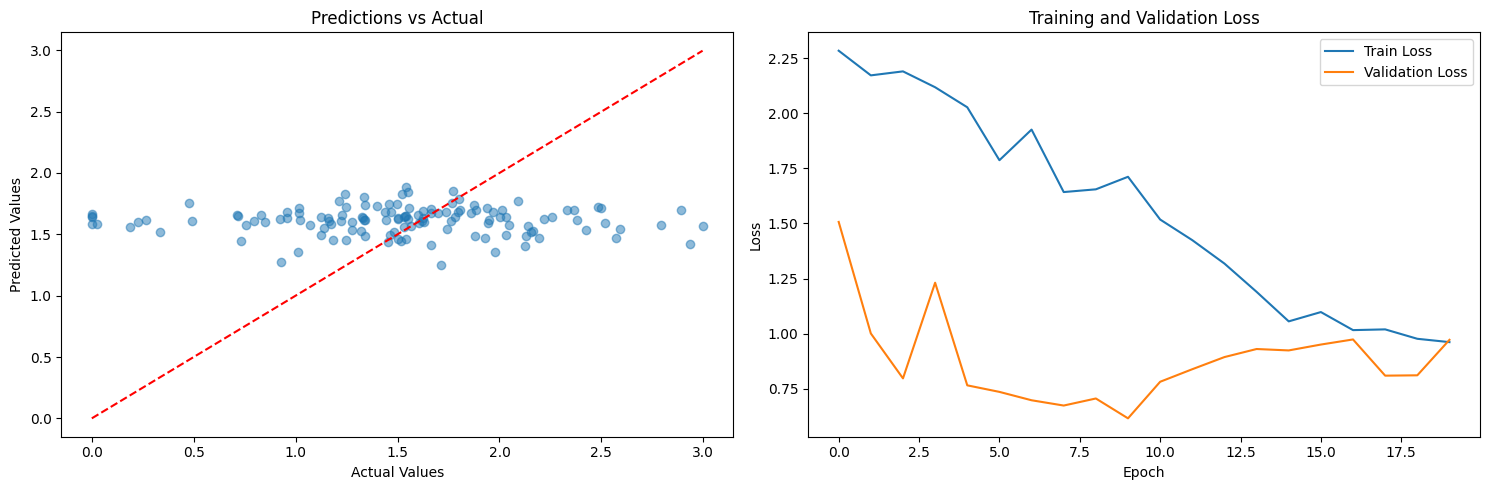


Regression Metrics:
Mean Squared Error: 0.4207
R² Score: -0.0674

Metrics for values > 2:
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
True Positives: 0
False Positives: 0
False Negatives: 27


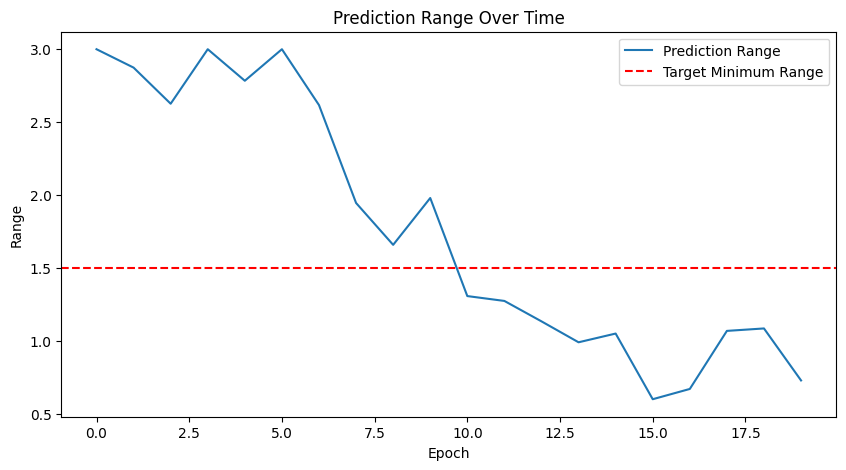


=== Running Linear Regression Approach ===
Loading CSV file...
Final shapes:
Mel features: (872, 80, 647)
BERT features: (872, 768)
Labels: (872,)

Linear Regression Metrics:
Mean Squared Error: 1.9511
R² Score: -4.4859


In [ ]:
# Main execution
if __name__ == "__main__":
    # Set up paths
    csv_path = '/content/drive/MyDrive/cs229_final_project/preprocessed_data.csv'
    base_path = '/content/drive/MyDrive/cs229_final_project/'

    # Choose which approach(es) to run
    run_dl = True  # Set to True to run deep learning
    run_lr = True  # Set to True to run linear regression

    models = {}
    results = {}

    if run_dl:
        models['deep_learning'], results['deep_learning'] = run_deep_learning_approach(csv_path, base_path)

    if run_lr:
        models['linear_regression'], results['linear_regression'] = run_linear_regression(csv_path, base_path)

    # Example of predicting a new song (if models were successfully trained) - COMMENTED OUT FOR NOW
    # if 'deep_learning' in models and mod  els['deep_learning'] is not None:
    #     print("\nTesting prediction on a new song...")
    #     new_mel_path = 'path/to/new/mel_spectrogram.npy'
    #     new_lyrics_path = 'path/to/new/bert_features.npy'
    #     prediction = predict_new_song_deep_learning(
    #         new_mel_path,
    #         new_lyrics_path,
    #         models['deep_learning'],
    #         base_path
    #     )